In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data_utils import *        
from src.models import DeepONet
from src.pinn_train_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"

time_start = "2018-01-01"
time_end = "2022-12-31"

zarr_ds = load_data(data_dir, time_start=time_start, time_end=time_end)

In [115]:
batch_size = 100
train_loader, test_loader = get_data_loaders(zarr_ds, 0.8, batch_size=batch_size)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
D = 0.1
dx = (zarr_ds.lon[1] - zarr_ds.lon[0]).values
dy = (zarr_ds.lat[1] - zarr_ds.lat[0]).values

In [98]:
from src.models import *

In [116]:
from torch.optim.lr_scheduler import OneCycleLR

model = DeepONet(9, 2, 64, 50, (176, 240)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()
# scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2, verbose=True)
lambda_phys = 0.25

In [118]:
type(scheduler)

torch.optim.lr_scheduler.OneCycleLR

In [111]:
torch.cuda.empty_cache()
num_sensors = 1000
n_epochs = 100
scheduler = OneCycleLR(
    opt, max_lr=2e-3, steps_per_epoch=len(train_loader), epochs=n_epochs
)
train_losses, test_losses = train(
    model,
    opt,
    criterion,
    train_loader,
    test_loader,
    device,
    num_epochs=n_epochs,
    lambda_physics=lambda_phys,
    scheduler=scheduler,
    num_sensors=num_sensors,
)

Training epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 0.0198, Val Loss: 0.0205, Val phys. Loss: 0.0032


Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.


Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.


Epoch 20/100, Train Loss: 0.0191, Val Loss: 0.0198, Val phys. Loss: 0.0033


Epoch 00021: reducing learning rate of group 0 to 6.2500e-05.


Epoch 00025: reducing learning rate of group 0 to 3.1250e-05.


Epoch 00028: reducing learning rate of group 0 to 1.5625e-05.


Epoch 30/100, Train Loss: 0.0190, Val Loss: 0.0199, Val phys. Loss: 0.0034


Epoch 00031: reducing learning rate of group 0 to 7.8125e-06.


Epoch 00034: reducing learning rate of group 0 to 3.9063e-06.


Epoch 00037: reducing learning rate of group 0 to 1.9531e-06.


Epoch 40/100, Train Loss: 0.0189, Val Loss: 0.0199, Val phys. Loss: 0.0034
Epoch 00040: reducing learning rate of group 0 to 9.7656e-07.


Epoch 00043: reducing learning rate of group 0 to 4.8828e-07.


Epoch 00046: reducing learning rate of group 0 to 2.4414e-07.


Epoch 00049: reducing learning rate of group 0 to 1.2207e-07.


Epoch 50/100, Train Loss: 0.0189, Val Loss: 0.0199, Val phys. Loss: 0.0035


Epoch 00052: reducing learning rate of group 0 to 6.1035e-08.


Epoch 00055: reducing learning rate of group 0 to 3.0518e-08.


Epoch 60/100, Train Loss: 0.0189, Val Loss: 0.0198, Val phys. Loss: 0.0034


Epoch 00061: reducing learning rate of group 0 to 1.5259e-08.


Epoch 70/100, Train Loss: 0.0189, Val Loss: 0.0198, Val phys. Loss: 0.0034


Epoch 80/100, Train Loss: 0.0189, Val Loss: 0.0198, Val phys. Loss: 0.0034


Epoch 90/100, Train Loss: 0.0189, Val Loss: 0.0199, Val phys. Loss: 0.0034


Epoch 100/100, Train Loss: 0.0190, Val Loss: 0.0199, Val phys. Loss: 0.0034


In [42]:
def sample_grid(model, x):
    torch.cuda.empty_cache()
    height, width = (176, 240)

    # Create a regular grid of normalized coordinates
    y_coords = torch.linspace(-1, 1, height)
    x_coords = torch.linspace(-1, 1, width)
    grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing="ij")
    grid_coords = torch.stack((grid_x, grid_y), dim=-1).to(device)

    # Reshape grid coordinates for the DeepONet input
    grid_coords = grid_coords.unsqueeze(0).expand(batch_size, -1, -1, -1)
    grid_coords_flat = grid_coords.reshape(batch_size, -1, 2)

    output = torch.zeros((batch_size, height, width)).to(device)
    chunk_size = 2000  # Adjust based on your GPU memory
    for i in range(0, height * width, chunk_size):
        chunk_coords = grid_coords_flat[:, i : i + chunk_size, :]
        with torch.no_grad():
            chunk_output = model(x, chunk_coords)
        output.view(batch_size, -1)[:, i : i + chunk_size] = chunk_output.squeeze(-1)

    return output.cpu().numpy()

In [112]:
x, y = next(iter(train_loader))
x = x.to(device)
output = sample_grid(model, x)

Text(0.5, 1.0, 'Target')

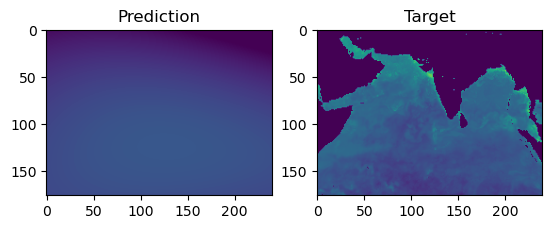

In [113]:
fig, ax = plt.subplots(1, 2)
i = 3
ax[0].imshow(output[i, :, :], clim=(0, 1))
# ax[0].imshow(output[i, :, :])
ax[0].set_title("Prediction")
ax[1].imshow(y[i, :, :], clim=(0, 1))
ax[1].set_title("Target")

In [154]:
with torch.no_grad():
    out = model(x, grid_coords_flat)

OutOfMemoryError: CUDA out of memory. Tried to allocate 212.70 GiB. GPU 0 has a total capacty of 23.64 GiB of which 22.15 GiB is free. Including non-PyTorch memory, this process has 1.48 GiB memory in use. Of the allocated memory 640.90 MiB is allocated by PyTorch, and 653.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [86]:
from src.plotting_utils import plot_output


def get_output(model, x):
    model.eval()
    with torch.no_grad():
        inputs = x.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()

    return outputs

In [106]:
x, y = next(iter(test_loader))
outputs = get_output(model, x)

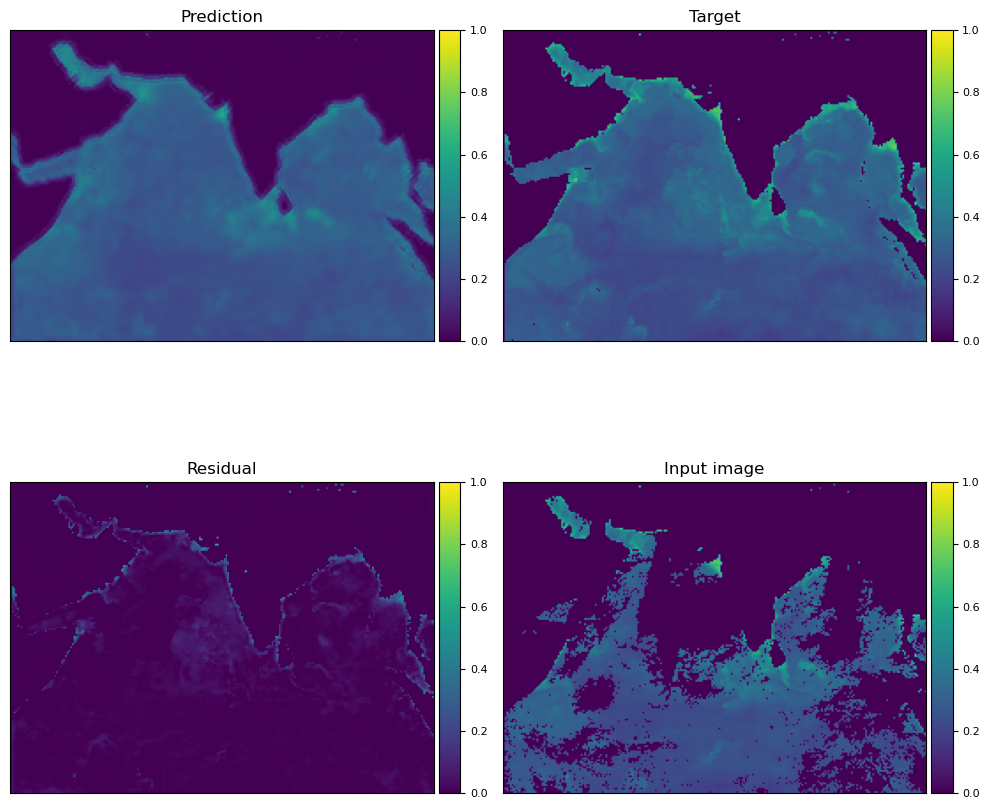

In [108]:
plot_output(outputs, x, y, batch_ind=10, figsize=(10, 10))

In [109]:
def sample_sensors(features, num_sensors, seed=None):
    """
    Sample random locations from the image to act as sensors.

    :param features: Input features tensor (batch_size, channels, height, width)
    :param num_sensors: Number of sensor locations to sample
    :param seed: Random seed for reproducibility
    :return: Sampled sensor locations and their corresponding values
    """
    if seed is not None:
        torch.manual_seed(seed)

    batch_size, channels, height, width = features.shape

    # Sample random locations
    locations = torch.randint(0, height * width, (batch_size, num_sensors))
    y_coords = locations // width
    x_coords = locations % width

    # Get values at sampled locations
    idx = (
        torch.arange(batch_size).unsqueeze(1),
        torch.arange(channels).unsqueeze(0).unsqueeze(-1),
        y_coords.unsqueeze(1),
        x_coords.unsqueeze(1),
    )
    sensor_values = features[idx].permute(0, 2, 1)

    # Normalize coordinates to [-1, 1] range
    normalized_coords = torch.stack(
        [
            2 * x_coords.float() / (width - 1) - 1,
            2 * y_coords.float() / (height - 1) - 1,
        ],
        dim=-1,
    )

    return normalized_coords, sensor_values

In [110]:
sample_sensors(x, 100)

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32, 1], [1, 9, 1], [32, 1, 100], [32, 1, 100]

In [126]:
features, target, num_sensors = x, y, 100
batch_size, channels, height, width = features.shape

# Sample random locations
y_coords = torch.randint(0, height, (batch_size, num_sensors))
x_coords = torch.randint(0, width, (batch_size, num_sensors))

# Get values at sampled locations
batch_indices = torch.arange(batch_size).unsqueeze(1).expand(-1, num_sensors)
sensor_values = target[batch_indices, y_coords, x_coords]

# Normalize coordinates to [-1, 1] range
normalized_coords = torch.stack(
    [2 * x_coords.float() / (width - 1) - 1, 2 * y_coords.float() / (height - 1) - 1],
    dim=-1,
)

In [128]:
sensor_values.shape

torch.Size([32, 100])

In [125]:
y.shape

torch.Size([32, 176, 240])